# Neural Networks

This notebook shows the work we did to find a neural network capable of solving the Milestone 1

#### Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import time
import pickle
import sys
import re

## 1.Data

### 1.1 Import

In [4]:
df = {}
for t in ['train', 'test', 'val'] :
    df[t] = pd.read_csv(f"Data/{t}_set.csv")
df['train'].head(5)

,0.01,0.02,0.022,0.025,0.029,0.03,0.032,0.035,0.036,0.04,...,8.5,9.0,9.5,10.0,sa_avg,da5_75,da5_95,fiv3,sa_ratio,sat1_col
0,0.011075,0.011107,0.011132,0.011176,0.011274,0.011288,0.011341,0.011377,0.011422,0.011567,...,0.000247,0.000223,0.000206,0.000190,0.010809,14.484,21.416,2.881797,0.832237,0.78
1,0.155380,0.153050,0.154590,0.156281,0.161038,0.160171,0.159765,0.166164,0.173643,0.174708,...,0.002316,0.002225,0.002106,0.001998,0.031044,14.430,18.270,7.642059,0.961638,1.96
2,0.060774,0.060783,0.060790,0.060795,0.060799,0.060800,0.060804,0.060794,0.060793,0.060798,...,0.013225,0.012226,0.011904,0.011696,0.098425,16.700,35.105,42.218868,1.737888,1.39
3,0.016016,0.016088,0.016106,0.016135,0.016198,0.016218,0.016263,0.016401,0.016445,0.016595,...,0.000192,0.000163,0.000139,0.000124,0.010169,7.320,17.370,2.599605,1.000551,1.97
4,0.030632,0.030699,0.030724,0.030738,0.030785,0.030809,0.030811,0.030818,0.030856,0.031014,...,0.004094,0.003350,0.002638,0.002224,0.037375,28.005,41.635,11.434507,1.371310,1.43


#### Columns options :

We want to be able to reduce the number of columns we give to our model

In [83]:
X_col = {}
y_col = ['sat1_col']
#Option 1 : All
X_col["All"] = df['test'].columns.to_numpy()
#Option 2 : Reduce to last columns (no sa(T), only the other columns. sa_ratio and sa_avg is there to convey the sa information)
X_col["Reduced"] = ['1.3','sa_avg','da5_75', 'da5_95', 'fiv3', 'sa_ratio']
#Option 3 : Best 15 cols (section 9.)
X_col['Best_15'] = ['0.085', '5.5', '0.7', '0.14', '0.065', '2.5', '1.8', '0.42', '0.38', '2.2'
, '0.029', '0.03', '5.0', '3.2', '0.032']

KeyError: 'test'

### 1.2 Data Expansion : Max Period

We add a new column to our data : the period with the maximum $s_a(T)$.

In [6]:
for t in ['train', 'test', 'val'] :
    df[t]['max_period'] = df[t][df['test'].columns.difference(X_col["Reduced"]+["max_period"])].idxmax(axis="columns").astype("float")

In [9]:
#Visualisation : 
df['val']['max_period'][15:25]

15    1.200
16    0.190
17    0.060
18    0.220
19    0.133
20    0.500
21    0.160
22    0.360
23    0.300
24    1.400
Name: max_period, dtype: float64

We add the corresponding options

In [10]:
#Options 4 and 4.1 : Add max_period
X_col["Red_max_period"] = ['sa_avg','da5_75', 'da5_95', 'fiv3', 'sa_ratio', 'max_period']
X_col["All_max_period"] = df['test'].columns.to_numpy()

We choose the maximum option, as it brought us the best results

In [12]:
#Choix :
columns = "All_max_period" #We had the best result with this

We import this in numpy for the normalisation step

In [14]:
X_train = df['train'][X_col[columns]].to_numpy()
y_train = df['train'][y_col].to_numpy()

X_val = df['val'][X_col[columns]].to_numpy()
y_val = df['val'][y_col].to_numpy()

X_test = df['test'][X_col[columns]].to_numpy()

cols_map = np.array(X_col[columns])

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(12646, 111)
(3000, 111)
(1500, 111)


### 1.3 Normalisation

Now we normalise our data :

In [17]:
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

def Normalise(X):
    return (X-mean)/std

X_train = Normalise(X_train)
X_val = Normalise(X_val)
X_test = Normalise(X_test)

### 1.3 Import en Pytorch

https://stackoverflow.com/questions/44429199/how-to-load-a-list-of-numpy-arrays-to-pytorch-dataset-loader

In [16]:
def convert_to_dataloader(x, y=None, batch_size = 100):
    tensor_x = torch.Tensor(x)
    try:
        if y == None:
            dataset = torch.utils.data.TensorDataset(tensor_x)
    except:
        tensor_y = torch.Tensor(y)
        dataset = torch.utils.data.TensorDataset(tensor_x,tensor_y)
    return torch.utils.data.DataLoader(dataset, batch_size = batch_size)

dataload_train = convert_to_dataloader(X_train, y_train)
dataload_val = convert_to_dataloader(X_val, y_val)
dataload_test = convert_to_dataloader(X_test)

## 2. Models

All our models take a `cols` argument with the size of the data (to adjust in function of the different columns options we had)

### 2.1 OneLayerNet

In [18]:
class OneLayerNet(nn.Module):
    """1-Layer linear"""
    
    def __init__(self, cols):
        super().__init__()
        self.fc1 = nn.Linear(cols, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        return x
  
    def predict(self, x: torch.Tensor) -> torch.Tensor:
        y = self.forward(x)
        return y

one_layer_net = OneLayerNet(X_train.shape[1])

### 2.2 ThreeLayerNet

In [19]:
class ThreeLayerNet(nn.Module):
    """3-Layer linear+RELU"""
    
    def __init__(self, cols):
        super().__init__()
        self.fc1 = nn.Linear(cols, cols//2)
        self.fc2 = nn.Linear(cols//2, cols//4)
        self.fc3 = nn.Linear(cols//4, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = self.fc2(F.relu(x))
        x = self.fc3(F.relu(x))
        return x
  
    def predict(self, x: torch.Tensor) -> torch.Tensor:
        y = self.forward(x)
        return y

three_layer_net = ThreeLayerNet(X_train.shape[1])

### 2.3 FourLayerNet

In [27]:
class FourLayerNet(nn.Module):
    """4-Layer with some x^2 terms"""
    
    def __init__(self, cols):
        super().__init__()
        self.fc1 = nn.Linear(cols, cols//2)
        self.fc2 = nn.Linear(cols//2, cols//4)
        self.fc3 = nn.Linear(2*(cols//4), cols//4)
        self.fc4 = nn.Linear(cols//4, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = self.fc2(F.gelu(x))
        x2 = x**2
        x = torch.stack([x, x2], dim=2).flatten(start_dim=1) # Adding x^2 terms
        x = self.fc3(F.relu(x))
        x = self.fc4(F.relu(x))
        return x

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        y = self.forward(x)
        return y

four_layer_net = FourLayerNet(X_train.shape[1])

### 2.4 NonLinearNet

In [28]:
class NonLinearNet(nn.Module):
    """Non-linear 4-Layer NEt : We add x^2 ,log, exp terms after the first layer"""
    
    def __init__(self, cols):
        super().__init__()
        self.fc1 = nn.Linear(cols, cols//4)
        self.fc2 = nn.Linear(4*(cols//4), cols//2)
        self.fc3 = nn.Linear(cols//2, cols//8)
        self.fc4 = nn.Linear(cols//8, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = torch.stack([x, x**2, torch.log(x+1e-3), torch.exp(x)], dim=2).flatten(start_dim=1) # Adding x^2, log, exp terms
        x = self.fc2(F.gelu(x))
        x = self.fc3(F.relu(x))
        x = self.fc4(F.relu(x))
        return x

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        y = self.forward(x)
        return y

non_linear_net = NonLinearNet(X_train.shape[1])

### 2.5 FourLayerNet3

In [29]:
class FourLayerNet3(nn.Module):
    """4-Layer net with x^2, x^3, x^4 terms after the second layer"""
    
    def __init__(self, cols):
        super().__init__()
        self.fc1 = nn.Linear(cols, cols//2)
        self.fc2 = nn.Linear(cols//2, cols//4)
        self.fc3 = nn.Linear(4*(cols//4), cols//4)
        self.fc4 = nn.Linear(cols//4, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = self.fc2(F.gelu(x))
        x2 = x**2
        x3 = x**3
        x4 = x**4
        x = torch.stack([x, x2, x3, x4], dim=2).flatten(start_dim=1)
        x = self.fc3(F.relu(x))
        x = self.fc4(F.relu(x))
        return x

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        y = self.forward(x)
        return y

four_layer_net3 = FourLayerNet3(X_train.shape[1])

### 2.6 TwoLayer

In [24]:
class TwoLayerNet(nn.Module):
    """2-Layer linear+RELU"""
    
    def __init__(self, cols):
        super().__init__()
        self.fc1 = nn.Linear(cols, cols//6)
        self.fc2 = nn.Linear(cols//6, 1)
     

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = self.fc2(F.relu(x))
        return x
  
    def predict(self, x: torch.Tensor) -> torch.Tensor:
        y = self.forward(x)
        return y

two_layer_net = TwoLayerNet(X_train.shape[1])

#works well with SGD
# optimizer = optim.SGD(model.parameters(), lr=0.0001) and epoch 1000 


### 2.7 FiveLayerNetRacine

In [25]:
class FiveLayerNetRacine(nn.Module):
    """4-Layer linear+RELU + Non-linear"""
    
    def __init__(self, cols):
        super().__init__()
        self.fc1 = nn.Linear(cols, cols//2)
        self.fc2 = nn.Linear(cols//2, cols//4)
        self.norm2 = torch.nn.BatchNorm1d(2*(cols//4))
        self.fc3 = nn.Linear(2*(cols//4), cols//4)
        self.fc4 = nn.Linear(cols//4, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = self.fc2(F.relu(x))
        x2 = x.sign() * torch.sqrt(x.abs())
        x = torch.stack([x, x2], dim=2).flatten(start_dim=1) # Adding x^2 terms
        x = self.norm2(x)
        x = self.fc3(F.relu(x))
        x = self.fc4(F.relu(x))
        return x

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        y = self.forward(x)
        return y

five_layer_net_racine = FiveLayerNetRacine(X_train.shape[1])

### 2.8 FourLayerNetTwoThree

In [26]:
class FourLayerNetTwoThree(nn.Module):
    """4-Layer linear+RELU + Non-linear"""
    
    def __init__(self, cols):
        super().__init__()
        self.fc1 = nn.Linear(cols, cols//2)
        self.fc2 = nn.Linear(cols//2, cols//4)
        self.fc3 = nn.Linear(4*(cols//4), cols//4)
        self.fc4 = nn.Linear(cols//4, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = self.fc2(F.relu(x))
        x2 = x.sign() * torch.sqrt(x.abs())
        x3 = x**2
        x4 = x**3
        x = torch.stack([x, x2, x3, x4], dim=2).flatten(start_dim=1)
        x = self.fc3(F.relu(x))
        x = self.fc4(F.relu(x))
        return x

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        y = self.forward(x)
        return y

four_layer_net_two_three = FourLayerNetTwoThree(X_train.shape[1])

### 2.8 FourLayerNetTwo

In [30]:
# With a Racine and a Square
class FourLayerNetTwo(nn.Module):
    """4-Layer Net with racine and x^2 terms after the second layer"""
    
    def __init__(self, cols):
        super().__init__()
        self.fc1 = nn.Linear(cols, cols//2)
        self.fc2 = nn.Linear(cols//2, cols//4)
        self.fc3 = nn.Linear(3*(cols//4), cols//4)
        self.fc4 = nn.Linear(cols//4, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = self.fc2(F.relu(x))
        x2 = x.sign() * torch.sqrt(x.abs())
        x3 = x**2
        x = torch.stack([x, x2, x3], dim=2).flatten(start_dim=1)
        x = self.fc3(F.relu(x))
        x = self.fc4(F.relu(x))
        return x

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        y = self.forward(x)
        return y

four_layer_net_two_three = FourLayerNetTwoThree(X_train.shape[1])

### EightLayerNet

In [31]:
class EightLayerNet(nn.Module):
    """An Eight Layer Net with onlu linear layers and Relu"""

    def __init__(self, cols):
        super().__init__()
        self.fc1 = nn.Linear(cols, cols//2)
        self.fc2 = nn.Linear(cols//2, cols//4)
        self.fc3 = nn.Linear(cols//4, cols//6)
        self.fc4 = nn.Linear(cols//6, cols//10)
        self.fc5 = nn.Linear(cols//10 , cols//16)
        self.fc6 = nn.Linear(cols//16 , cols//20)
        self.fc7 = nn.Linear(cols//20 , cols//24)
        self.fc8 = nn.Linear(cols//24 , 1)
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = self.fc2(F.relu(x))
        x = self.fc3(F.relu(x))
        x = self.fc4(F.relu(x))
        x = self.fc5(F.relu(x))
        x = self.fc6(F.relu(x))
        x = self.fc7(F.relu(x))
        x = self.fc8(F.relu(x))
        return x

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        y = self.forward(x)
        return y

eight_layer_net = EightLayerNet(X_train.shape[1])
#With adamW loss 0.1458 - 30 epochs 

## 3. Training

### 3.1 Loss function

In [32]:
loss_fn = nn.MSELoss(reduction="mean")

### 3.2 Training, test, export routine

In [33]:
def test(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader):
    """
    Evaluates the model against the passed dataloader. 
    
    A small approximation is made when taking the mean even if the last batch might not be of the same size.
    """

    model.eval()
    losses = []
    
    with torch.no_grad():
        for data, target in dataloader:
            # Forward pass
            out = model(data)
            
            losses.append(loss_fn(out,target).item())
        ### END CODE HERE ###
            
    return np.mean(losses)

In [34]:
def export_test(model: torch.nn.Module, prefix = "", suffix = time.time()):
    """
    Exports the result of the model against the dataset.
    File is saved in folder "submissions", with the name "{prefix}{model name}_{suffix}.csv"

    Args :
        model : A torch.nn.Module neural net
        prefix : A string which will be appended in front of the model name (Default : "")
        suffix : A string which will be appended after the model name (Defaults to the timestamp)
    """

    model_name = model.__repr__().split('(')[0] #Taking the model name

    y_test = model(torch.Tensor(X_test))
    df_out = pd.DataFrame(y_test.detach().numpy())
    df_out.columns = ['sat1_col']
    df_out.to_csv(f"submissions/{prefix}{model_name}_{suffix}.csv", index=False)

In [72]:
def train(model: torch.nn.Module, train_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer, epochs: int, do_be_printing: bool = True, id=""):
    """
        A train routine for our models.

        Args :
            model : the model to be trained
            train_loader : the dataloader with the train set
            loss_fn : the loss function
            optimizer : the optimizer

            epochs : the number of epochs to run the loop
            do_be_printing : Whether to print the loss at every epoch (default : True)
            id : a string to be added to the eventual exported files
    """

    # Initialize arrays for loss and accuracy
    losses_train = []
    losses_val = []
    
    # Sets the module in training mode
    model.train()
    
    for epoch in range(1, epochs + 1):
        losses = []
        
        # Iterate through data
        for data, target in train_loader:
            
            # Zero-out the gradients
            optimizer.zero_grad()
            
            # Forward pass
            out = model(data)
            
            # Compute loss
            loss = loss_fn(out, target)
            
            # Backward pass
            loss.backward()
            
            # Optimizer step
            optimizer.step()
            
            # Update losses for this epoch
            losses.append(loss.item())
            
        # End of epoch, compute val and train loss
        val_loss = test(model, dataload_val)
        train_loss = np.mean(losses)
        
        losses_train.append(train_loss)
        losses_val.append(val_loss)

        if epoch % 10 == 0:
            if do_be_printing:
                print(epoch, train_loss, val_loss) #Print the val loss every 10 epochs

            if(np.mean(losses_val[-5:])-0.02 > np.mean(losses_val[-10:])): #Stop execution if validation loss is increasing by more than 0.02 points
                return
            if val_loss < 0.16: #If validation loss is lower than 0.16, export
                export_test(model, "sapin", f"{val_loss:.3f}_{str(optimizer).split()[0]}{id}") #We add  a prefix with the name of a tree to differentiate different running sessions. We love trees
        else:
            if do_be_printing:
                print(epoch, train_loss) #Print loss at every epoch

    return losses_train, losses_val #Return arrays for future analysis

## 4. Choosing Best Model 

We now need to choose the best model from the different ones we have created.

### 4.1 Functions

To complete this task, we will run all models and compare the results

#### To run all models

In [37]:
def save(val_loss):
    """
        Logs the model and results in a file for future analysis 
    """
    f= open("history.txt", "a+")
    f.write(f"""
    ------------

    {model}

    Columns : {columns}
    VAL LOSS : {val_loss}""")
    f.close()

In [38]:
def save_object(obj, filename: str="result_all_models"):
    """
        Save an object in pickle and numpy files
        
        Args :
            filename : A str without extensions
    """
    with open(f"{filename}.pkl", 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)
    np.save(f"{filename}.npy", obj) 

def recover_result(filename: str):
    """
        Load an object from a pickle file
        
        Args :
            filename : A str without extensions
    """
    with open(f"{filename}.pkl", 'rb') as input:
        obj = pickle.load(input)
    return obj

In [40]:
def testing_all_models(models, optims, n_epochs: int, id: bool=False):
    """
        Tests multiple models with multiple optimizers

        Args :
            - models : A list with the class of the Models to train
            - optims : A list of tuples (Optim, kwargs) with the optimizer class Optim and the kwargs to be passed to it
            - n_epochs : The number of epochs to run each model
            - id 

        Returns :
            - exports : a dictionary {
                    "{model name} - {optimizer name}" : [
                        model,
                        [train loss at each epoch],
                        [val loss at each epoch],
                    ],
                }
                
    """

    exports = {}
    for Model in models:   
        i=0
        for Optim, kargs in optims:
            model = Model(X_train.shape[1])
            optimizer = Optim(model.parameters(), **kargs)
            name = str(model).split("(")[0] + " - " + str(optimizer).split()[0]
            if id:
                i+=1
                name=name+str(i)
            try:
                if id:
                    loss_train, val_loss = train(model, dataload_train, loss_fn, optimizer, epochs=n_epochs, do_be_printing = False, id=i)
                else:
                    loss_train, val_loss = train(model, dataload_train, loss_fn, optimizer, epochs=n_epochs, do_be_printing = False)
                exports[name] = (model, loss_train, val_loss)
                print(f"{name} : {np.min([loss_train, val_loss], axis=1)}")
                #save(np.min(val_loss))
            except:
                print(f"{name} : failed {sys.exc_info()[0]}")
    return exports

In [41]:
def run_more_epochs(models_to_run_df, optims_list, n_epochs):
    """
        Run the models for more epochs:
        
        Args :
            models_to_run_df : A Dataframe returned by get_df_from_result()
            optims_list : The list which was passed to testing_all_models()
            n_epochs : The number of epochs to run it more
        
        Return the updated Dataframe
    """

    optim_dict = {str(Optim).split(".")[-1].split("'")[0]:(Optim, kargs) for Optim, kargs in optims_list}

    for row in models_to_run_df.itertuples():
        model = row.model
        Optim, kargs = optim_dict[row.Index[1]]
        optimizer = Optim(model.parameters(), **kargs)
        try:
            #Run for more epochs
            new_loss_train, new_val_loss = train(model, dataload_train, loss_fn, optimizer, epochs=n_epochs, do_be_printing = False)

            #Update the dataframe
            models_to_run_df.loc[row.Index]["train losses"] = np.concatenate([row._4, new_loss_train], axis=0)
            models_to_run_df.loc[row.Index]["val losses"] = np.concatenate([row._5, new_val_loss], axis=0)
            models_to_run_df.loc[row.Index]["model"] = model
            models_to_run_df.loc[row.Index]["best train loss"] = np.min(models_to_run_df.loc[row.Index]["train losses"])
            models_to_run_df.loc[row.Index]["best val loss"] = np.min(models_to_run_df.loc[row.Index]["val losses"])
            models_to_run_df.loc[row.Index]["best epoch"] = np.argmin(models_to_run_df.loc[row.Index]["val losses"])
            
            #print result
            print(f"{row.Index} : {np.min([new_loss_train, new_val_loss], axis=1)}")
        except:
            print(f"{row.Index} : failed {sys.exc_info()[0]}")
    return models_to_run_df
                   

    


#### To analyse the results

In [42]:
def plot_losses(result) -> None:
    """
        Plot the losses of each run against the number of epoch

        Arg :
            result : The result object returned by testing_all_methods()
    """
    n = len(result)
    cols = np.min([int(n**0.5), 5])
    rows = int(n//cols )+1
    plt.figure(figsize=(20,40))
    i = 0

    for name, data in result.items():
        i+=1
        x = np.arange(0,len(data[1]))
        plt.subplot(rows, cols, i)
        plt.plot(x, data[1], label = f"train")
        plt.plot(x, data[2], label = f"val")
        plt.title(name)
        plt.ylim([0.1,0.2])
        plt.legend()
        
    #Show losses progress
    plt.show()

In [43]:
def get_df_from_results(result):
    """
        Returns a DataFrame from a result object

        Arg :
            result : The result object returned by testing_all_methods()

        Returns:
            df : a Dataframe, indexed by "model" and "optimiser", with the following columns
                - "best train loss" : The lowest train loss
                - "best val loss" : The lowest val loss
                - "best epoch" : The epoch which achieved the best validation loss
                - "train losses" : A list with the train loss at each epoch
                - "val losses" : A list with the val loss at each epoch
                - "model" : The model
    """
    dataout = []

    for name, data in result.items():
        best_epoch = np.argmin(data[2])
        model, optimiser = tuple(name.split(" - "))
        best_val_loss = np.min(data[2])
        best_train_loss = np.min(data[1])

        dataout.append([model, optimiser, best_train_loss, best_val_loss, best_epoch, data[1], data[2], data[0]])
    
    dataout = np.array(dataout)
    index=  pd.MultiIndex.from_arrays([dataout[:,0],dataout[:,1]], names = ["model", "optimiser"])
    df = pd.DataFrame(dataout[:, 2:], index = index, columns = ['best train loss', 'best val loss', 'best epoch', "train losses", "val losses", "model"])
    return df

### 4.2 Analyse

Let's start by running all models with all optimisers with default values

In [ ]:
models = [ThreeLayerNet, FourLayerNet, NonLinearNet, FourLayerNet3, TwoLayerNet, FiveLayerNetRacine, FourLayerNetTwoThree, EightLayerNet, ]
optims = [(torch.optim.SGD, {"lr":1e-3}),
            (torch.optim.Adadelta, {}),
            (torch.optim.Adagrad, {}),
            (torch.optim.Adam, {}),
            (torch.optim.AdamW, {}),
            (torch.optim.Adamax, {}),
            (torch.optim.LBFGS, {}),
            (torch.optim.RMSprop, {}),
            (torch.optim.ASGD, {}),
            (torch.optim.Rprop, {})]
result = testing_all_models(models, optims, 0) #We ran it with 100 epochs
save_object(result, f"Pickles/dummy") #Save result object for analysis later on. We changed the file name to avoid overwriting our previous results

ThreeLayerNet - SGD : failed <class 'ValueError'>
ThreeLayerNet - Adadelta : failed <class 'ValueError'>
ThreeLayerNet - Adagrad : failed <class 'ValueError'>
ThreeLayerNet - Adam : failed <class 'ValueError'>
ThreeLayerNet - AdamW : failed <class 'ValueError'>
ThreeLayerNet - Adamax : failed <class 'ValueError'>
ThreeLayerNet - LBFGS : failed <class 'ValueError'>
ThreeLayerNet - RMSprop : failed <class 'ValueError'>
ThreeLayerNet - ASGD : failed <class 'ValueError'>
ThreeLayerNet - Rprop : failed <class 'ValueError'>
FourLayerNet - SGD : failed <class 'ValueError'>
FourLayerNet - Adadelta : failed <class 'ValueError'>
FourLayerNet - Adagrad : failed <class 'ValueError'>
FourLayerNet - Adam : failed <class 'ValueError'>
FourLayerNet - AdamW : failed <class 'ValueError'>
FourLayerNet - Adamax : failed <class 'ValueError'>
FourLayerNet - LBFGS : failed <class 'ValueError'>
FourLayerNet - RMSprop : failed <class 'ValueError'>
FourLayerNet - ASGD : failed <class 'ValueError'>
FourLayerNet 

In [45]:
#Recovering results from file
result = recover_result('Pickles/result_all')

Let's plot the results :

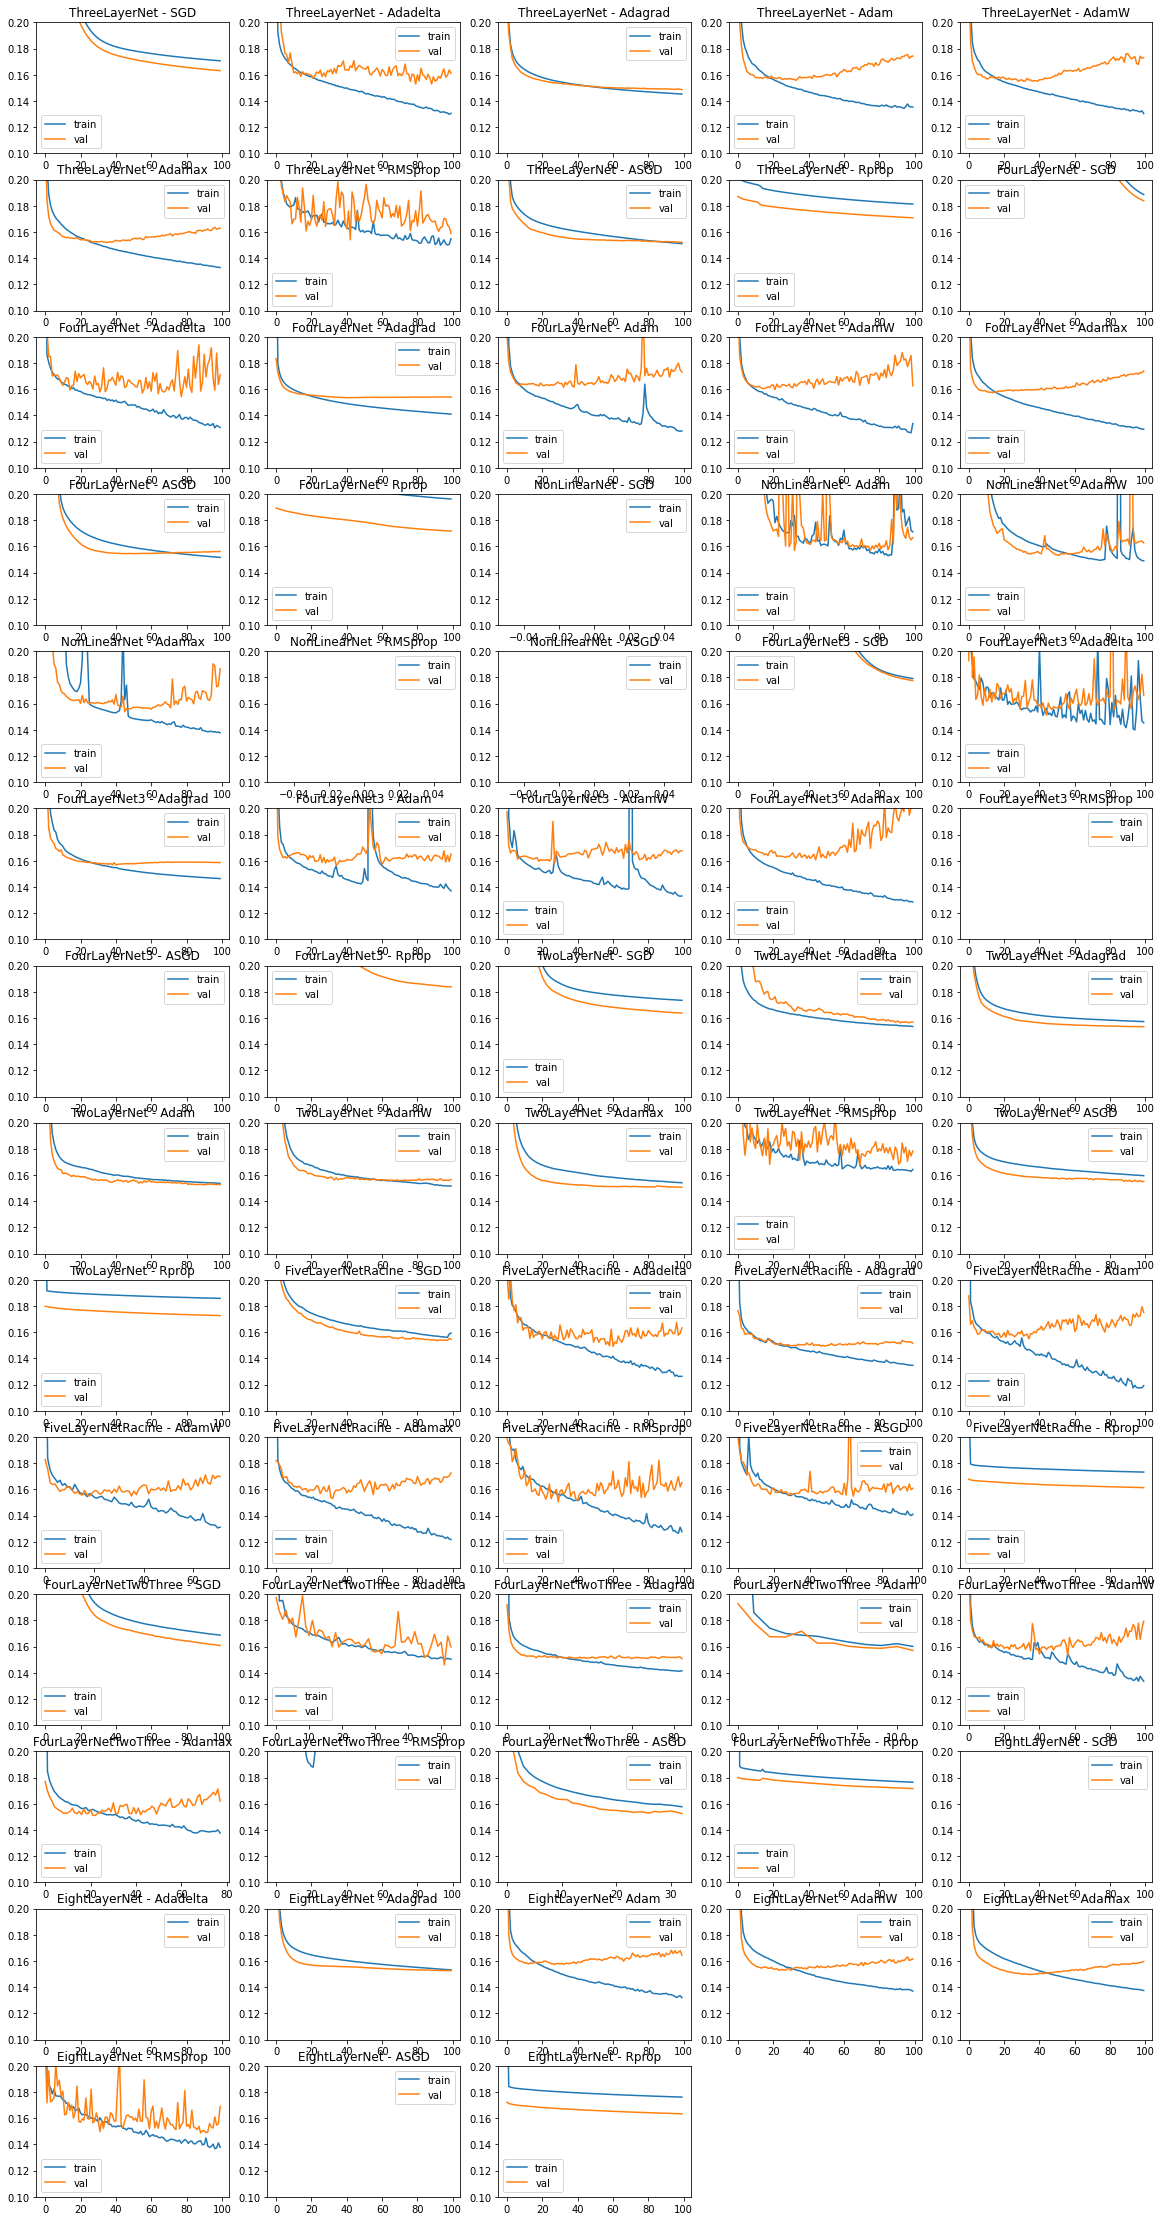

In [46]:
#Plot losses evolution for each :
plot_losses(result)

In [47]:
#Get a df with result of each run :
df = get_df_from_results(result)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


<AxesSubplot:title={'center':'Best Epoch'}, ylabel='Frequency'>

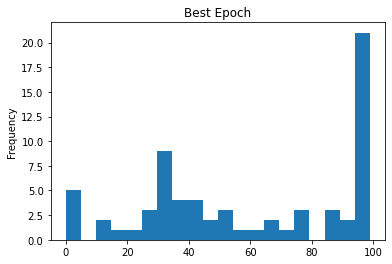

In [ ]:
df["best epoch"].plot.hist(bins=20, title="Best Epoch")

On observe deux comportements principaux : Soit la meilleure époque est autour de 30, soit elle est à 99.

Nous allons séparer ces deux groupes de modèles :

#### A. Best epoch ~ 30

In [ ]:
df_30 = df[df["best epoch"]>25][df["best epoch"] < 40][df["best val loss"]<0.155]
df_30

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


best train loss  best val loss  best epoch
model              optimiser                                            
ThreeLayerNet      Adamax            0.132853       0.151937        35.0
FiveLayerNetRacine Adamax            0.121776       0.153018        32.0
                   RMSprop           0.126546       0.150464        29.0
EightLayerNet      AdamW             0.137022       0.152848        30.0
                   Adamax            0.137505       0.149797        35.0

On va maintenant travailler sur les paramètres des optimisers

In [49]:
models = [ThreeLayerNet, FiveLayerNetRacine, EightLayerNet]
optims = [  (torch.optim.Adamax, {"lr":0.002, "betas":(0.9, 0.999), "eps":1e-08, "weight_decay":0}), #Default, for control
            (torch.optim.Adamax, {"lr":0.001, "betas":(0.9, 0.999), "eps":1e-08, "weight_decay":0}),
            (torch.optim.Adamax, {"lr":0.001, "betas":(0.9, 0.999), "eps":1e-08, "weight_decay":0.1}),
            (torch.optim.Adamax, {"lr":0.002, "betas":(0.85, 0.9999), "eps":1e-08, "weight_decay":0.1}),
            (torch.optim.Adamax, {"lr":0.001, "betas":(0.9, 0.99), "eps":1e-08, "weight_decay":0}),
            (torch.optim.Adamax, {"lr":0.0005, "betas":(0.9, 0.999), "eps":1e-08, "weight_decay":0}),
            (torch.optim.RMSprop, {}),
            (torch.optim.RMSprop, {"lr":0.01, "alpha":0.99, "eps":1e-08, "weight_decay":0, "momentum":0, "centered":False}),
            (torch.optim.RMSprop, {"lr":0.005, "alpha":0.99, "eps":1e-08, "weight_decay":0, "momentum":0, "centered":False}),
            (torch.optim.RMSprop, {"lr":0.001, "alpha":0.99, "eps":1e-08, "weight_decay":0, "momentum":0, "centered":False}),
            (torch.optim.RMSprop, {"lr":0.0005, "alpha":0.99, "eps":1e-08, "weight_decay":0, "momentum":0, "centered":False}),
            (torch.optim.RMSprop, {"lr":0.01, "alpha":0.95, "eps":1e-08, "weight_decay":0, "momentum":0, "centered":False}),
            (torch.optim.RMSprop, {"lr":0.01, "alpha":0.9, "eps":1e-08, "weight_decay":0, "momentum":0, "centered":False}),
            (torch.optim.RMSprop, {"lr":0.01, "alpha":0.99, "eps":1e-08, "weight_decay":0.1, "momentum":0, "centered":False}),
            (torch.optim.RMSprop, {"lr":0.01, "alpha":0.99, "eps":1e-08, "weight_decay":0, "momentum":0.1, "centered":False}),
            (torch.optim.RMSprop, {"lr":0.01, "alpha":0.99, "eps":1e-08, "weight_decay":0, "momentum":0, "centered":True}),
            ]
result = testing_all_models(models, optims, 1, id=True)#We ran it for 100 epochs
save_object(result, f"Pickles/dummy") #Save result object for analysis later on. We changed file name to avoid overwriting

ThreeLayerNet - Adamax1 : failed <class 'NameError'>
ThreeLayerNet - Adamax2 : failed <class 'NameError'>
ThreeLayerNet - Adamax3 : failed <class 'NameError'>
ThreeLayerNet - Adamax4 : failed <class 'NameError'>
ThreeLayerNet - Adamax5 : failed <class 'NameError'>
ThreeLayerNet - Adamax6 : failed <class 'NameError'>
ThreeLayerNet - RMSprop7 : failed <class 'NameError'>
ThreeLayerNet - RMSprop8 : failed <class 'NameError'>
ThreeLayerNet - RMSprop9 : failed <class 'NameError'>
ThreeLayerNet - RMSprop10 : failed <class 'NameError'>
ThreeLayerNet - RMSprop11 : failed <class 'NameError'>
ThreeLayerNet - RMSprop12 : failed <class 'NameError'>
ThreeLayerNet - RMSprop13 : failed <class 'NameError'>
ThreeLayerNet - RMSprop14 : failed <class 'NameError'>
ThreeLayerNet - RMSprop15 : failed <class 'NameError'>
ThreeLayerNet - RMSprop16 : failed <class 'NameError'>
FiveLayerNetRacine - Adamax1 : failed <class 'NameError'>
FiveLayerNetRacine - Adamax2 : failed <class 'NameError'>
FiveLayerNetRacine 

In [50]:
#récupération des résultats :
result = recover_result("Pickles/result_best30")

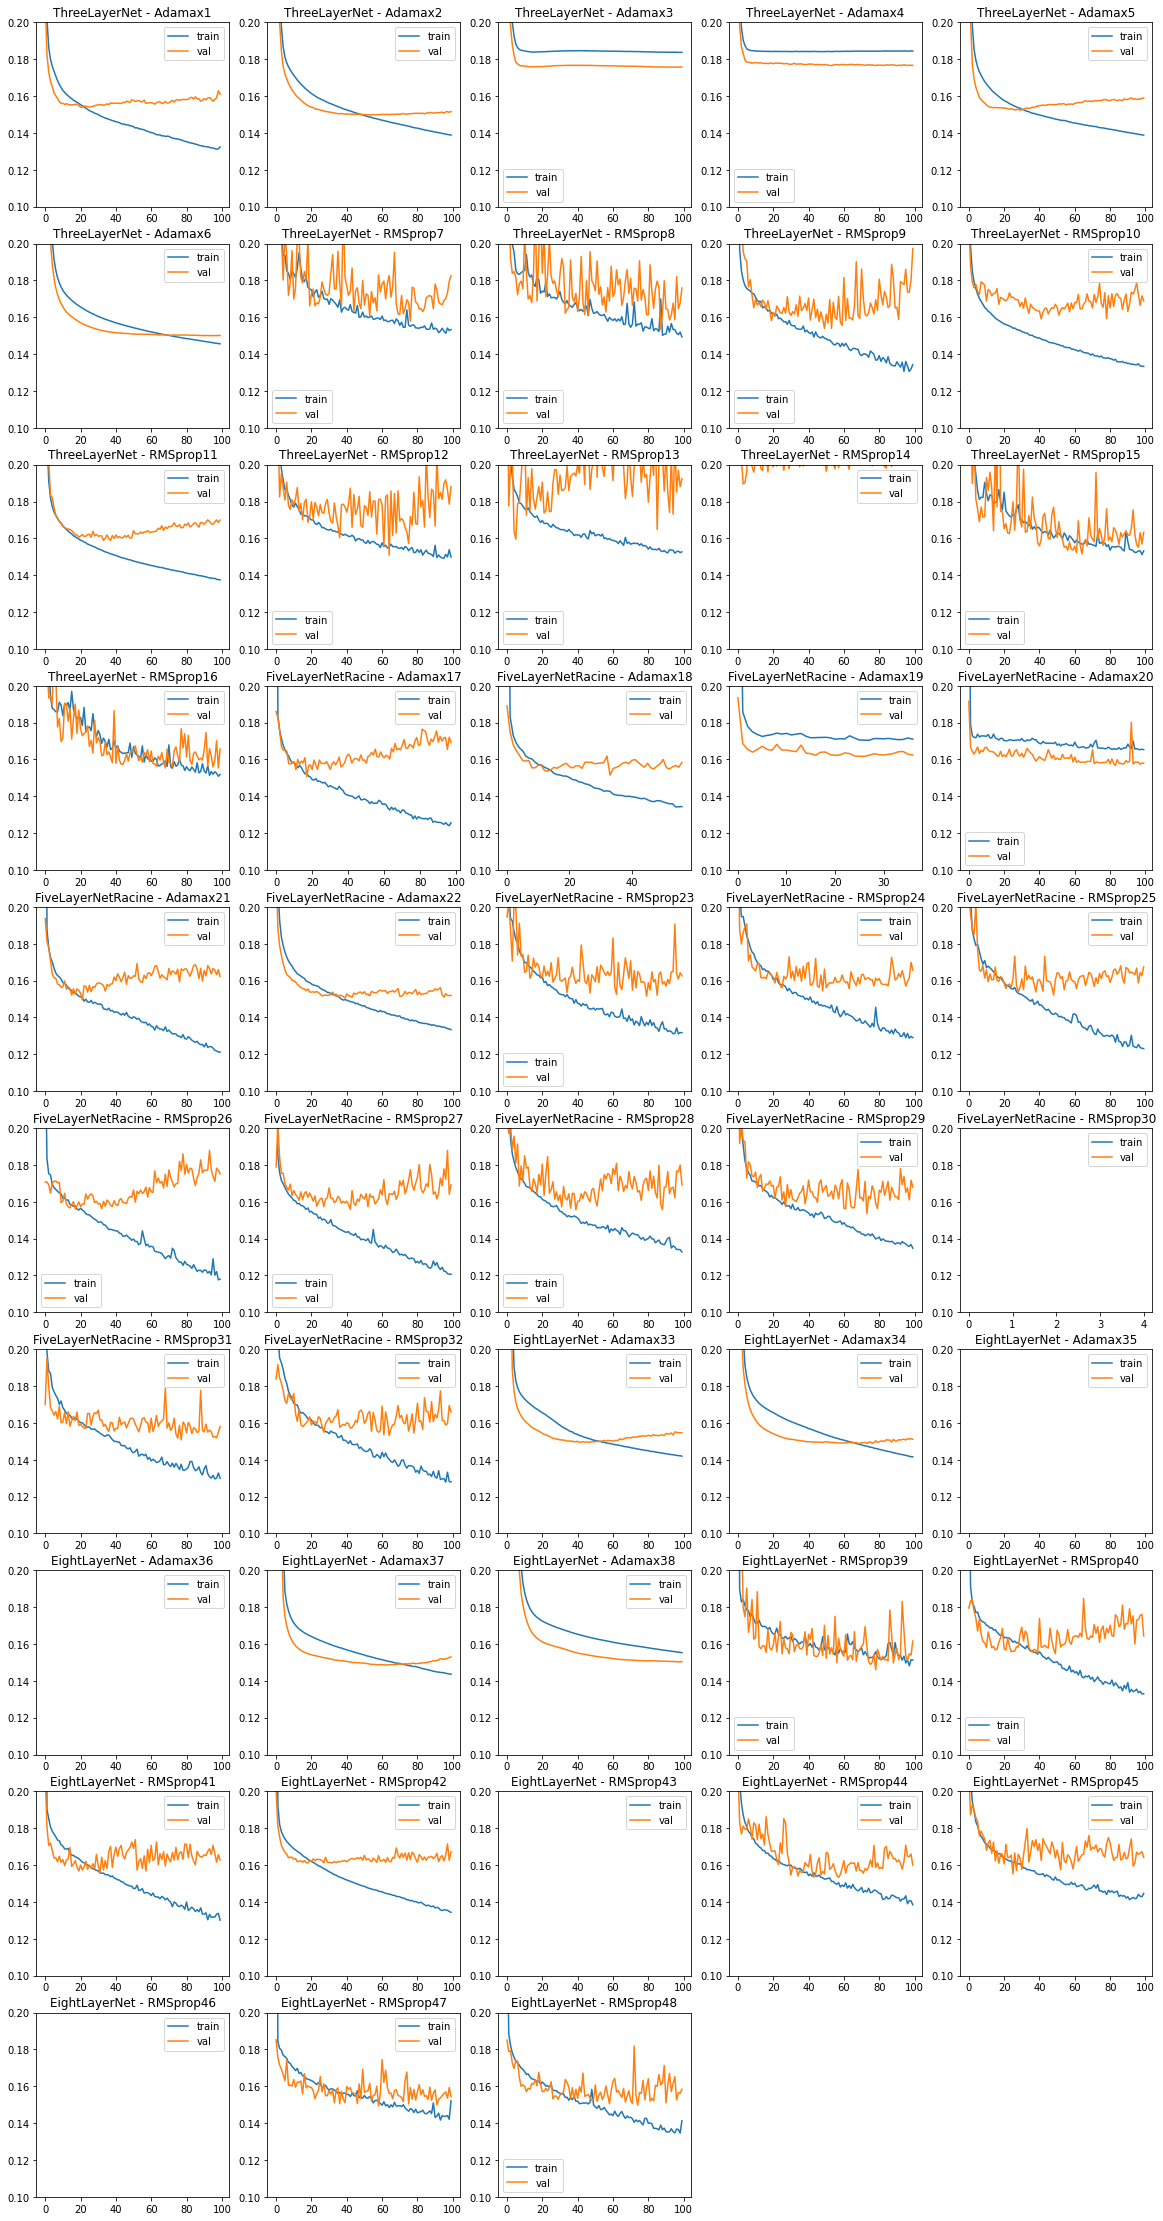

In [51]:
plot_losses(result)

In [53]:
df = get_df_from_results(result)
df.sort_values("best val loss").head(10)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


best train loss best val loss best epoch  \
model              optimiser                                            
EightLayerNet      RMSprop39        0.148155      0.146014         78   
                   Adamax37         0.143621      0.148588         63   
                   Adamax34         0.141558      0.148794         69   
                   RMSprop47        0.141605      0.149307         58   
                   Adamax33         0.141909      0.149378         41   
FiveLayerNetRacine Adamax21         0.121184       0.14954         21   
EightLayerNet      RMSprop48        0.134542      0.149667         74   
ThreeLayerNet      Adamax2          0.138875       0.14975         53   
                   Adamax6          0.145577      0.150009         93   
EightLayerNet      Adamax38         0.155285      0.150277         98   

                                                                   train losses  \
model              optimiser                                                      
EightLayerNet      RMSprop39  [0.33465198169308386, 0.18958968352379763, 0.1...   
                   Adamax37   [1.5560609102249146, 0.8805625607648234, 0.380...   
                   Adamax34   [0.6679489206610703, 0.33520878663682563, 0.25...   
                   RMSprop47  [0.3991439839399706, 0.18406066239818814, 0.18...   
                   Adamax33   [1.5365272978628715, 0.5341596220891307, 0.348...   
FiveLayerNetRacine Adamax21   [0.5146181247835084, 0.18759635618821843, 0.17...   
EightLayerNet      RMSprop48  [0.25392871854577476, 0.18834325184268275, 0.1...   
ThreeLayerNet      Adamax2    [0.7790046641676445, 0.31267880536909176, 0.22...   
                   Adamax6    [0.7065708864861586, 0.3730712074229098, 0.272...   
EightLayerNet      Adamax38   [2.0596196773483997, 1.0094578512540953, 0.625...   

                                                                     val losses  \
model              optimiser                                                      
EightLayerNet      RMSprop39  [0.206655024488767, 0.24274819393952687, 0.226...   
                   Adamax37   [1.191464074452718, 0.42028758525848386, 0.301...   
                   Adamax34   [0.3555038571357727, 0.27483275135358176, 0.21...   
                   RMSprop47  [0.18519344329833984, 0.17583833833535512, 0.1...   
                   Adamax33   [0.5996067126592001, 0.41712520718574525, 0.25...   
FiveLayerNetRacine Adamax21   [0.19371945063273113, 0.1813552722334862, 0.17...   
EightLayerNet      RMSprop48  [0.18506502161423366, 0.17888166805108388, 0.1...   
ThreeLayerNet      Adamax2    [0.39977948665618895, 0.23622512022654216, 0.1...   
                   Adamax6    [0.41484099825223286, 0.3010787030061086, 0.22...   
EightLayerNet      Adamax38   [1.5726738055547078, 0.6395189086596171, 0.561...   

                                                                          model  
model              optimiser                                                     
EightLayerNet      RMSprop39  EightLayerNet(\n  (fc1): Linear(in_features=11...  
                   Adamax37   EightLayerNet(\n  (fc1): Linear(in_features=11...  
                   Adamax34   EightLayerNet(\n  (fc1): Linear(in_features=11...  
                   RMSprop47  EightLayerNet(\n  (fc1): Linear(in_features=11...  
                   Adamax33   EightLayerNet(\n  (fc1): Linear(in_features=11...  
FiveLayerNetRacine Adamax21   FiveLayerNetRacine(\n  (fc1): Linear(in_featur...  
EightLayerNet      RMSprop48  EightLayerNet(\n  (fc1): Linear(in_features=11...  
ThreeLayerNet      Adamax2    ThreeLayerNet(\n  (fc1): Linear(in_features=11...  
                   Adamax6    ThreeLayerNet(\n  (fc1): Linear(in_features=11...  
EightLayerNet      Adamax38   EightLayerNet(\n  (fc1): Linear(in_features=11...

We will avoid RMSprop because it is very unstable. Also, it didn't really improve

Adamax got better on the EightLayerNet when we reduced the learning rate, added weight decay and when we reduced the betas. Let's continue :


In [ ]:
models = [EightLayerNet]
optims = [  (torch.optim.Adamax, {"lr":0.0015, "betas":(0.85, 0.999), "eps":1e-08, "weight_decay":0}),  #>1
            (torch.optim.Adamax, {"lr":0.001, "betas":(0.85, 0.999), "eps":1e-08, "weight_decay":0}),   #2
            (torch.optim.Adamax, {"lr":0.0005, "betas":(0.85, 0.9999), "eps":1e-08, "weight_decay":0}), #3
            (torch.optim.Adamax, {"lr":0.0015, "betas":(0.8, 0.999), "eps":1e-08, "weight_decay":0}),   #4
            (torch.optim.Adamax, {"lr":0.0015, "betas":(0.85, 0.999), "eps":1e-08, "weight_decay":0.01}),  #5
            (torch.optim.Adamax, {"lr":0.001, "betas":(0.85, 0.999), "eps":1e-08, "weight_decay":0.01}),   #6
            (torch.optim.Adamax, {"lr":0.0005, "betas":(0.85, 0.9999), "eps":1e-08, "weight_decay":0.01}), #7
            (torch.optim.Adamax, {"lr":0.0015, "betas":(0.8, 0.999), "eps":1e-08, "weight_decay":0.01}),   #8
            (torch.optim.Adamax, {"lr":0.001, "betas":(0.8, 0.999), "eps":1e-08, "weight_decay":0.01}),    #9
            (torch.optim.Adamax, {"lr":0.0005, "betas":(0.8, 0.9999), "eps":1e-08, "weight_decay":0.01}),  #10
            (torch.optim.Adamax, {"lr":0.0015, "betas":(0.85, 0.999), "eps":1e-08, "weight_decay":0}),  #11 #Again to have at least one working
            (torch.optim.Adamax, {"lr":0.001, "betas":(0.85, 0.999), "eps":1e-08, "weight_decay":0}),   #12
            (torch.optim.Adamax, {"lr":0.0005, "betas":(0.85, 0.9999), "eps":1e-08, "weight_decay":0}), #13
            (torch.optim.Adamax, {"lr":0.0015, "betas":(0.8, 0.999), "eps":1e-08, "weight_decay":0}),   #14
            (torch.optim.Adamax, {"lr":0.0015, "betas":(0.85, 0.999), "eps":1e-08, "weight_decay":0.01}),  #15
            (torch.optim.Adamax, {"lr":0.001, "betas":(0.85, 0.999), "eps":1e-08, "weight_decay":0.01}),   #16
            (torch.optim.Adamax, {"lr":0.0005, "betas":(0.85, 0.9999), "eps":1e-08, "weight_decay":0.01}), #17
            (torch.optim.Adamax, {"lr":0.0015, "betas":(0.8, 0.999), "eps":1e-08, "weight_decay":0.01}),   #18
            (torch.optim.Adamax, {"lr":0.001, "betas":(0.8, 0.999), "eps":1e-08, "weight_decay":0.01}),    #19
            (torch.optim.Adamax, {"lr":0.0005, "betas":(0.8, 0.9999), "eps":1e-08, "weight_decay":0.01}),  #10
            ]
result = testing_all_models(models, optims, 0, id=True) #We ran it for 200 epochs
save_object(result, f"Pickles/dummy") #Save result object for analysis later on. Changed filename to avoid overwriting

EightLayerNet - Adamax1 : [0.12337341 0.15324084]
EightLayerNet - Adamax2 : [0.13426846 0.14991743]
EightLayerNet - Adamax3 : [0.3124722  0.29732724]
EightLayerNet - Adamax4 : [0.13205843 0.1532238 ]
EightLayerNet - Adamax5 : [0.1600609  0.15455372]
EightLayerNet - Adamax6 : [0.31255596 0.29738266]
EightLayerNet - Adamax7 : [0.31250878 0.29732414]
EightLayerNet - Adamax8 : [0.15966581 0.15326278]
EightLayerNet - Adamax9 : [0.31254702 0.29733351]
EightLayerNet - Adamax10 : [0.31250877 0.29732441]
EightLayerNet - Adamax11 : [0.12913507 0.15654715]
EightLayerNet - Adamax12 : [0.1321949  0.14897815]
EightLayerNet - Adamax13 : [0.14421052 0.14715628]
EightLayerNet - Adamax14 : [0.3124932  0.29734194]
EightLayerNet - Adamax15 : [0.31259792 0.29732504]
EightLayerNet - Adamax16 : [0.15881448 0.15378178]
EightLayerNet - Adamax17 : [0.31251161 0.29734617]
EightLayerNet - Adamax18 : [0.31253807 0.29733935]
EightLayerNet - Adamax19 : [0.15975572 0.15434444]
EightLayerNet - Adamax20 : [0.15995284 0

In [57]:
result = recover_result("Pickles/result_8Layer_Adamax_200epochs")
df = get_df_from_results(result)
df.sort_values("best val loss").head(5)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


best train loss best val loss best epoch  \
model         optimiser                                            
EightLayerNet Adamax13         0.144211      0.147156        139   
              Adamax12         0.132195      0.148978         56   
              Adamax2          0.134268      0.149917         86   
              Adamax4          0.132058      0.153224         81   
              Adamax1          0.123373      0.153241         37   

                                                              train losses  \
model         optimiser                                                      
EightLayerNet Adamax13   [1.4685194867802418, 0.6216609472130227, 0.380...   
              Adamax12   [2.3752924438536636, 1.7284648315174374, 0.672...   
              Adamax2    [2.77070222877142, 2.346439456376504, 2.024204...   
              Adamax4    [2.087511917737525, 0.7539509128867172, 0.4622...   
              Adamax1    [0.9907627483521859, 0.44163409990119185, 0.24...   

                                                                val losses  \
model         optimiser                                                      
EightLayerNet Adamax13   [1.0479270815849304, 0.38654036323229474, 0.33...   
              Adamax12   [1.967839773495992, 1.2288520336151123, 0.4459...   
              Adamax2    [2.4238826751708986, 2.091647171974182, 1.7913...   
              Adamax4    [0.8685522079467773, 0.5714101036389668, 0.336...   
              Adamax1    [0.6085929413636525, 0.2765185962120692, 0.204...   

                                                                     model  
model         optimiser                                                     
EightLayerNet Adamax13   EightLayerNet(\n  (fc1): Linear(in_features=11...  
              Adamax12   EightLayerNet(\n  (fc1): Linear(in_features=11...  
              Adamax2    EightLayerNet(\n  (fc1): Linear(in_features=11...  
              Adamax4    EightLayerNet(\n  (fc1): Linear(in_features=11...  
              Adamax1    EightLayerNet(\n  (fc1): Linear(in_features=11...

We see that the best one is this optimizer : `(torch.optim.Adamax, {"lr":0.001, "betas":(0.85, 0.999), "eps":1e-08, "weight_decay":0})`

#### B. Models who needed more epoch

In [58]:
#Recover the original run
result = recover_result("Pickles/result_all")

In [59]:
#Isolate the models concerned
df = get_df_from_results(result)
df_need_more_epochs = df[df["best epoch"] == 99]

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [60]:
optims = [(torch.optim.SGD, {"lr":1e-3}),
            (torch.optim.Adadelta, {}),
            (torch.optim.Adagrad, {}),
            (torch.optim.Adam, {}),
            (torch.optim.AdamW, {}),
            (torch.optim.Adamax, {}),
            (torch.optim.LBFGS, {}),
            (torch.optim.RMSprop, {}),
            (torch.optim.ASGD, {}),
            (torch.optim.Rprop, {})]
df = run_more_epochs(df_need_more_epochs, optims, n_epochs=00) #We ran it for 200 epochs
save_object(df, "Pickles/dummy_df") #Changed file name

('ThreeLayerNet', 'SGD') : failed <class 'NameError'>
('ThreeLayerNet', 'Adagrad') : failed <class 'NameError'>
('ThreeLayerNet', 'Rprop') : failed <class 'NameError'>
('FourLayerNet', 'SGD') : failed <class 'NameError'>
('FourLayerNet', 'Rprop') : failed <class 'NameError'>
('FourLayerNet3', 'SGD') : failed <class 'NameError'>
('FourLayerNet3', 'Rprop') : failed <class 'NameError'>
('TwoLayerNet', 'SGD') : failed <class 'NameError'>
('TwoLayerNet', 'Adam') : failed <class 'NameError'>
('TwoLayerNet', 'Adamax') : failed <class 'NameError'>
('TwoLayerNet', 'Rprop') : failed <class 'NameError'>
('FiveLayerNetRacine', 'Rprop') : failed <class 'NameError'>
('FourLayerNetTwoThree', 'SGD') : failed <class 'NameError'>
('FourLayerNetTwoThree', 'Rprop') : failed <class 'NameError'>
('EightLayerNet', 'SGD') : failed <class 'NameError'>
('EightLayerNet', 'Adagrad') : failed <class 'NameError'>
('EightLayerNet', 'ASGD') : failed <class 'NameError'>
('EightLayerNet', 'Rprop') : failed <class 'Name

In [64]:
df_need_more_epochs = recover_result("Pickles/df_more_epochs")
df_need_more_epochs


best train loss best val loss best epoch  \
model                optimiser                                            
ThreeLayerNet        SGD              0.160341      0.153357        299   
                     Adagrad          0.134311      0.148627        170   
                     Rprop            0.171234      0.162706        299   
FourLayerNet         SGD                0.1629      0.156626        299   
                     Rprop             0.17054      0.162109        299   
FourLayerNet3        SGD              0.162087      0.169851        225   
                     Rprop            0.459687      0.183707         99   
TwoLayerNet          SGD              0.165054      0.156886        299   
                     Adam              0.14532      0.150138        186   
                     Adamax           0.145911      0.149415        100   
                     Rprop            0.177795      0.163208        299   
FiveLayerNetRacine   Rprop            0.168218      0.155338        299   
FourLayerNetTwoThree SGD                   NaN           NaN        182   
                     Rprop             0.17647      0.162725        299   
EightLayerNet        SGD              0.300941      0.285968        299   
                     Adagrad          0.138761      0.149574        144   
                     ASGD             0.139423      0.151179        163   
                     Rprop            0.169848      0.156295        299   

                                                                     train losses  \
model                optimiser                                                      
ThreeLayerNet        SGD        [1.2828073449960844, 0.7362822798762735, 0.489...   
                     Adagrad    [0.326471188406306, 0.19839060388681456, 0.183...   
                     Rprop      [0.25319971003401, 0.2004492340360101, 0.19968...   
FourLayerNet         SGD        [1.5119103113497336, 0.9422756888735013, 0.646...   
                     Rprop      [0.3624468845879938, 0.21574916866585964, 0.21...   
FourLayerNet3        SGD        [1.4129498314669753, 0.8722980196081748, 0.585...   
                     Rprop      [60.22425896187467, 5.307352590513981, 5.18007...   
TwoLayerNet          SGD        [1.4831904416947852, 0.7496308128195485, 0.504...   
                     Adam       [0.8632573079405808, 0.34182553474358685, 0.25...   
                     Adamax     [0.7807599681568896, 0.3503125456609125, 0.273...   
                     Rprop      [0.2613096785709614, 0.191585335557855, 0.1913...   
FiveLayerNetRacine   Rprop      [0.23111682836934339, 0.17942568002723333, 0.1...   
FourLayerNetTwoThree SGD        [1.64224788476163, 0.7785235924983588, 0.40750...   
                     Rprop      [1.5072405964840117, 0.1886524625533209, 0.187...   
EightLayerNet        SGD        [1.1891579529431862, 0.6674678959245757, 0.434...   
                     Adagrad    [0.7282170085456428, 0.24607714893311028, 0.20...   
                     ASGD       [0.5964328802711382, 0.3126033248863821, 0.312...   
                     Rprop      [0.2667111259276473, 0.18420143671861783, 0.18...   

                                                                       val losses  \
model                optimiser                                                      
ThreeLayerNet        SGD        [0.8760991175969441, 0.5392101407051086, 0.386...   
                     Adagrad    [0.21521473030249277, 0.19192493855953216, 0.1...   
                     Rprop      [0.18707869549592335, 0.1863341470559438, 0.18...   
FourLayerNet         SGD        [1.0975926160812377, 0.7103398283322652, 0.508...   
                     Rprop      [0.18921533624331158, 0.18877175996700923, 0.1...   
FourLayerNet3        SGD        [1.0286145210266113, 0.6539618730545044, 0.457...   
                     Rprop      [0.48629057010014853, 0.43161316215991974, 0.3...   
TwoLayerNet          SGD        [0.9276791294415792, 0.544535468

In [ ]:
#Again for the slowest ones
df = run_more_epochs(df_need_more_epochs[df_need_more_epochs["best epoch"] == 299], optims, 0) #We ran it for 500 epochs
save_object(df_need_more_epochs, "Pickles/df_more_dummy") #Filename was changed

('ThreeLayerNet', 'SGD') : [0.14477843 0.14944847]
('ThreeLayerNet', 'Rprop') : [0.16247954 0.15523949]
('FourLayerNet', 'SGD') : [0.14386923 0.1521778 ]
('FourLayerNet', 'Rprop') : [0.16341018 0.15670738]
('TwoLayerNet', 'SGD') : [0.15227731 0.15150668]
('TwoLayerNet', 'Rprop') : [0.17188797 0.15823902]
('FiveLayerNetRacine', 'Rprop') : [0.16104123 0.15467929]
('FourLayerNetTwoThree', 'Rprop') : [0.17625582 0.16239181]
('EightLayerNet', 'SGD') : [0.15506109 0.14936073]
('EightLayerNet', 'Rprop') : [0.16558232 0.15337181]


In [68]:
df_need_more_epochs = recover_result("Pickles/df_more_more_epochs")
df_need_more_epochs.sort_values("best val loss")

,,best train loss,best val loss,best epoch,train losses,val losses,model
model,optimiser,,,,,,
ThreeLayerNet,SGD,0.153755,0.150852,595,"[1.2828073449960844, 0.7362822798762735, 0.489...","[0.8760991175969441, 0.5392101407051086, 0.386...",ThreeLayerNet(\n (fc1): Linear(in_features=11...
FourLayerNet,SGD,0.155022,0.153195,599,"[1.5119103113497336, 0.9422756888735013, 0.646...","[1.0975926160812377, 0.7103398283322652, 0.508...",FourLayerNet(\n (fc1): Linear(in_features=111...
EightLayerNet,SGD,0.161707,0.153383,599,"[1.1891579529431862, 0.6674678959245757, 0.434...","[0.8110833406448364, 0.47685575087865195, 0.34...",EightLayerNet(\n (fc1): Linear(in_features=11...
FiveLayerNetRacine,Rprop,0.165781,0.153847,599,"[0.23111682836934339, 0.17942568002723333, 0.1...","[0.16792431821425755, 0.16731854677200317, 0.1...",FiveLayerNetRacine(\n (fc1): Linear(in_featur...
TwoLayerNet,SGD,0.158879,0.153971,599,"[1.4831904416947852, 0.7496308128195485, 0.504...","[0.9276791294415792, 0.5445354680220286, 0.432...","TwoLayerNet(\n (fc1): Linear(in_features=111,..."
EightLayerNet,Rprop,0.166863,0.15421,599,"[0.2667111259276473, 0.18420143671861783, 0.18...","[0.17217626372973124, 0.17128676325082778, 0.1...",EightLayerNet(\n (fc1): Linear(in_features=11...
ThreeLayerNet,Rprop,0.167002,0.159161,599,"[0.25319971003401, 0.2004492340360101, 0.19968...","[0.18707869549592335, 0.1863341470559438, 0.18...",ThreeLayerNet(\n (fc1): Linear(in_features=11...
TwoLayerNet,Rprop,0.175641,0.159636,599,"[0.2613096785709614, 0.191585335557855, 0.1913...","[0.17995664924383165, 0.17962589412927626, 0.1...","TwoLayerNet(\n (fc1): Linear(in_features=111,..."
FourLayerNet,Rprop,0.169987,0.162109,299,"[0.3624468845879938, 0.21574916866585964, 0.21...","[0.18921533624331158, 0.18877175996700923, 0.1...",FourLayerNet(\n (fc1): Linear(in_features=111...


We see the two best are the ThreeLayerNet with Adagrad, TwoLayerNet with Adamax  and EightLayerNet with Adagrad.

Let's start with the ThreeLayerNet and EightLayerNet with Adagrad :


In [ ]:
models = [ThreeLayerNet, EightLayerNet]
optims = [  (torch.optim.Adagrad, {"lr":1e-2, "lr_decay":0, "eps":1e-08, "weight_decay":0}),  #1 (default)
            (torch.optim.Adagrad, {"lr":5e-3, "lr_decay":0, "eps":1e-08, "weight_decay":0}),  #2
            (torch.optim.Adagrad, {"lr":1e-3, "lr_decay":0, "eps":1e-08, "weight_decay":0}),  #3
            (torch.optim.Adagrad, {"lr":1e-2, "lr_decay":1e-3, "eps":1e-08, "weight_decay":0}),  #1 (default)
            (torch.optim.Adagrad, {"lr":5e-3, "lr_decay":1e-3, "eps":1e-08, "weight_decay":0}),  #2
            (torch.optim.Adagrad, {"lr":1e-3, "lr_decay":1e-3, "eps":1e-08, "weight_decay":0}),  #3
            (torch.optim.Adagrad, {"lr":1e-2, "lr_decay":0, "eps":1e-08, "weight_decay":0.1}),  #1 (default)
            (torch.optim.Adagrad, {"lr":5e-3, "lr_decay":0, "eps":1e-08, "weight_decay":0.1}),  #2
            (torch.optim.Adagrad, {"lr":1e-3, "lr_decay":0, "eps":1e-08, "weight_decay":0.1}),  #3
            ]
result = testing_all_models(models, optims, 500, id=True)
save_object(result, f"Pickles/result_Adagrad_500epochs") #Save result object for analysis later on.

ThreeLayerNet - Adagrad1 : [0.13299696 0.15148894]
ThreeLayerNet - Adagrad2 : [0.13871599 0.14774298]
ThreeLayerNet - Adagrad3 : [0.16274197 0.16091268]
ThreeLayerNet - Adagrad4 : [0.15497645 0.15544873]
ThreeLayerNet - Adagrad5 : [0.16453262 0.16110383]
ThreeLayerNet - Adagrad6 : [0.28664148 0.27649544]
ThreeLayerNet - Adagrad7 : [0.182088  0.1741061]
ThreeLayerNet - Adagrad8 : [0.17993207 0.17165787]
ThreeLayerNet - Adagrad9 : [0.17908457 0.17034571]
EightLayerNet - Adagrad1 : [0.13500563 0.14871932]
EightLayerNet - Adagrad2 : [0.14055337 0.14777121]
EightLayerNet - Adagrad3 : [0.17478588 0.17023018]
EightLayerNet - Adagrad4 : [0.16267089 0.15799772]
EightLayerNet - Adagrad5 : [0.16960163 0.16085412]
EightLayerNet - Adagrad6 : [0.86196591 0.84328593]
EightLayerNet - Adagrad7 : [0.20671529 0.1988711 ]
EightLayerNet - Adagrad8 : [0.31426135 0.2976123 ]


KernelInterrupted: Execution interrupted by the Jupyter kernel.

The execution was interupted towards the end so we didn't manage to save the result this time. However, here is the output which allowed us to continue :
``` 
ThreeLayerNet - Adagrad1 : [0.13299696 0.15148894]
ThreeLayerNet - Adagrad2 : [0.13871599 0.14774298]
ThreeLayerNet - Adagrad3 : [0.16274197 0.16091268]
ThreeLayerNet - Adagrad4 : [0.15497645 0.15544873]
ThreeLayerNet - Adagrad5 : [0.16453262 0.16110383]
ThreeLayerNet - Adagrad6 : [0.28664148 0.27649544]
ThreeLayerNet - Adagrad7 : [0.182088  0.1741061]
ThreeLayerNet - Adagrad8 : [0.17993207 0.17165787]
ThreeLayerNet - Adagrad9 : [0.17908457 0.17034571]
EightLayerNet - Adagrad1 : [0.13500563 0.14871932]
EightLayerNet - Adagrad2 : [0.14055337 0.14777121]
EightLayerNet - Adagrad3 : [0.17478588 0.17023018]
EightLayerNet - Adagrad4 : [0.16267089 0.15799772]
EightLayerNet - Adagrad5 : [0.16960163 0.16085412]
EightLayerNet - Adagrad6 : [0.86196591 0.84328593]
EightLayerNet - Adagrad7 : [0.20671529 0.1988711 ]
EightLayerNet - Adagrad8 : [0.31426135 0.2976123 ]
```

The only helping parameter to change was the learning rate, between `1e-2` and `5e-3`. However, the validation loss (even the test loss after a submission) where not significantly better. So we will continue with the EightLayerNet with this optimizer :
`(torch.optim.Adamax, {"lr":0.001, "betas":(0.85, 0.999), "eps":1e-08, "weight_decay":0})`

## 5. Train our model

We now train our model :

In [73]:
model = eight_layer_net
optimizer = torch.optim.Adamax(model.parameters(), lr=0.001, betas=(0.85, 0.999))
train(model, dataload_train, loss_fn = loss_fn, optimizer=optimizer, epochs = 140)

1 2.475301437490568
2 1.8336815280238474
3 1.3055692986240537
4 0.8766721674776453
5 0.575924346062142
6 0.4080833143840625
7 0.3387166376658312
8 0.31795827152691486
9 0.3133932100975607
10 0.3125676901087048 0.29749938249588015
11 0.30971771736783305
12 0.28128567197191434
13 0.23616283527744097
14 0.21426143984156332
15 0.19930009150833594
16 0.18898010318438838
17 0.18183207904963983
18 0.1769587840503595
19 0.17318855396171254
20 0.17028281157176325 0.16125485748052598
21 0.1682828406062652
22 0.16664108587062265
23 0.16489714337146189
24 0.16406287716364298
25 0.16318800728621446
26 0.16251531941449548
27 0.16152931884752483
28 0.16090212263694897
29 0.16037307210325255
30 0.15974784319795024 0.1550450975696246
31 0.15920417603310638
32 0.1586443230392426
33 0.15800534159414412
34 0.1576147559355563
35 0.15707320485293397
36 0.15657929683060157
37 0.15609900301366342
38 0.15570196086966145
39 0.1553652403861519
40 0.1549302222808515 0.1529987225929896
41 0.15451072496692025
42 0.

KeyboardInterrupt: 

## 6. Test on validation

In [74]:
val_loss = test(model, dataload_val)
val_loss

0.16321729272603988

## 7. Export Results

In [76]:
export_test(model)

## 8. Saving results for future purpose


In [77]:
save(val_loss)

## 9. Exploring weights : identifying which cols are used

We train our one_layer_net one time, and then check which inputs get the biggest weights.

In [84]:
model = one_layer_net
optimizer = torch.optim.SGD(model.parameters(),lr=1e-3)
_ = train(model, dataload_train, loss_fn, optimizer, 100)

1 0.2014344370975269
2 0.20142486949605265
3 0.2014153567472781
4 0.2014058970912235
5 0.2013965013224309
6 0.20138715659304868
7 0.2013778709403173
8 0.20136863497767862
9 0.20135945181442996
10 0.20135032737583625 0.193549378712972
11 0.20134125702728436
12 0.2013322353715033
13 0.2013232659284524
14 0.2013143501647814
15 0.2013054805712437
16 0.20129666694505946
17 0.20128789608638117
18 0.20127917990440458
19 0.20127051593515816
20 0.20126189708005726 0.19348320215940476
21 0.20125333231499815
22 0.20124480984811707
23 0.20123633548734696
24 0.20122790888069184
25 0.2012195316707994
26 0.20121119558576525
27 0.20120291059880746
28 0.20119466861401955
29 0.20118647350335683
30 0.20117832145353 0.19342375795046488
31 0.20117020929657567
32 0.2011621456563942
33 0.20115413035698762
34 0.20114615319047388
35 0.20113822260475533
36 0.20113032950660376
37 0.2011224839865692
38 0.20111467712742137
39 0.2011069092224902
40 0.20109918948233596 0.19337033977111182
41 0.20109150406178528
42 0

In [85]:
weightss = torch.Tensor(list(one_layer_net.parameters())[0]).detach().numpy().reshape((-1))
#print(weightss)
print(cols_map[np.argsort(np.abs(weightss))])
#print(cols_map[np.argsort(weightss)])

['0.14' '1.8' '5.5' '0.09' '0.07' '2.2' '0.022' '0.42' '0.7' '0.029'
 '0.03' '2.5' '0.085' '4.2' '5.0' '0.13' '10.0' '0.05' '0.02' '0.25' '0.2'
 '0.6' '0.26' '2.6' '0.19' '0.32' '7.0' '7.5' '0.38' '2.4' '8.0' '0.044'
 '0.065' '0.032' '9.5' '6.0' '4.0' '8.5' '3.2' '0.025' '0.4' '0.65'
 '0.075' '0.3' '2.0' '4.4' '0.15' '0.08' '1.9' '0.46' '0.042' '0.133'
 '1.7' '0.35' '0.24' '0.095' '3.4' '0.55' '0.17' '0.046' '0.067' '4.6'
 '0.9' '0.12' '0.36' '0.04' '0.28' '0.055' '3.8' '0.44' '3.0' '0.667'
 '2.8' '1.4' '1.6' '0.22' '0.45' '0.18' '9.0' '0.48' '6.5' '0.85' '1.1'
 '1.5' '0.035' '0.16' '0.29' '0.75' 'da5_75' 'max_period' '0.045' '4.8'
 '0.01' '0.95' '0.06' '0.048' '3.6' '0.11' '0.8' '1.0' '0.1' '0.5' '0.34'
 '3.5' '0.036' '1.3' 'fiv3' '1.2' 'da5_95' 'sa_ratio' 'sa_avg']


We note, interestingly, that none of the `sa_ratio` and the `1.3` columns are well used. This is interesting because the `sa_ratio` was dicovered in the dataset and was equal to the ratio of the `1.3` column and the `sa_avg` column. The creators of this dataset apparently gave it a more important value than the other columns, but our models do not find any link.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=493ee647-e437-4c81-80f8-96d4eefd9c39' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>